In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import math
import time
from numba import jit
from mpl_toolkits.mplot3d import Axes3D


from matplotlib.colors import LinearSegmentedColormap
import functools
import itertools as IT
import scipy.ndimage as ndimage
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [6]:
# comoving but the strings stay put (ideal for radiation or matter)


@jit(nopython = True)
def Laplacian(A,deltax,deltat):

    h = len(A)
    #CFL condition delta x => sqrt(D) delta t, where D is the number of dimensions            
    P = np.zeros((h,h,h))
    result = np.zeros((h,h,h))

  
    for i in range(0, h):
        for j in range(0,h):
            for k in range(0,h):
                P[i,j,k] = (A[(i-1)%h,(j-1)%h,(k-1)%h] + 3*A[(i-1)%h,j,(k-1)%h] + A[(i-1)%h,(j+1)%h,(k-1)%h] \
                + 3*A[(i-1)%h,(j-1)%h,k] + 14*A[(i-1)%h,j,k] + 3*A[(i-1)%h,(j+1)%h,k] \
                + A[(i-1)%h,(j-1)%h,(k+1)%h] + 3*A[(i-1)%h,j,(k+1)%h] + A[(i-1)%h,(j+1)%h,(k+1)%h] \
                + 3*A[i,(j-1)%h,(k-1)%h] + 14*A[i,j,(k-1)%h] + 3*A[i,(j+1)%h,(k-1)%h] \
                + 14*A[i,(j-1)%h,k] - 128*A[i,j,k] + 14*A[i,(j+1)%h,k] \
                + 3*A[i,(j-1)%h,(k+1)%h] + 14*A[i,j,(k+1)%h] + 3*A[i,(j+1)%h,(k+1)%h] \
                + A[(i+1)%h,(j-1)%h,(k-1)%h] + 3*A[(i+1)%h,j,(k-1)%h] + A[(i+1)%h,(j+1)%h,(k-1)%h] \
                + 3*A[(i+1)%h,(j-1)%h,k] + 14*A[(i+1)%h,j,k] + 3*A[(i+1)%h,(j+1)%h,k] \
                + A[(i+1)%h,(j-1)%h,(k+1)%h] + 3*A[(i+1)%h,j,(k+1)%h] + A[(i+1)%h,(j+1)%h,(k+1)%h])/(30*pow(deltax,2))
    return P 


def update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,a,time):
    H_0 = 2.18e-18
    #a = np.sqrt(2*H_0)*np.sqrt(time)
    a = 4.75240000000367e-36 * time**2
    beta = 0
    alpha = 3
    #era = 1 #radiation
    era = 2 #matter

    lam = 2*pow(math.pi,2)/pow(omega,2)
    

    
    F1 = Laplacian(A1,deltax,deltat) - a**beta * lam*A1*(pow(A1,2)+pow(A2,2)-pow(eta,2))-alpha*era*vel1
    F2 = Laplacian(A2,deltax,deltat) - a**beta * lam*A2*(pow(A1,2)+pow(A2,2)-pow(eta,2))-alpha*era*vel2
    
    time = time + deltat
    
    a1 = 4.75240000000367e-36 * time**2

    
    A1 = A1 + deltat*(vel1 + 0.5*deltat*F1) 
    A2 = A2 + deltat*(vel2 + 0.5*deltat*F2) 

    
    vel1 = vel1 + deltat/2*(F1 + Laplacian(A1,deltax,deltat) - a1**beta *lam*A1*(pow(A1,2)+pow(A2,2)-pow(eta,2)) -alpha*era*vel1) 
    vel2 = vel2 + deltat/2*(F2 + Laplacian(A2,deltax,deltat) - a1**beta *lam*A2*(pow(A1,2)+pow(A2,2)-pow(eta,2)) -alpha*era*vel2)
    
    
    return A1,A2,vel1,vel2,a,time
    
    
#change the values accordlingly    
def wolff(N,t0,t,A1,A2,vel,omega,eta,deltax,deltat):

    time = t0
    a = 0

    vel1 = vel
    vel2 = vel
    

    fig = plt.figure(figsize=(8,8))
    #fig.set_facecolor('springgreen')
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_facecolor('springgreen')
    #ax.set_axis_off()

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    m = 5
    
    #ones = np.ones((N,N,N))
    #ones = np.where(ones > 0)
    #ax.scatter(ones[0],ones[1],ones[2],color = 'purple',alpha = 0.1)
    

 
    #angle = np.arctan2(A2,A1)



    for i in np.arange(int(t/deltat)):
        time = round(time,2)
        
        if time <= m*5: 
            if time % 5 == 0:
                mod = np.where(np.sqrt(pow(A1,2)+pow(A2,2))**1 < 0.5)

                scat = ax.scatter(mod[0],mod[1],mod[2],color= 'black')

                plt.savefig('3/'+str(int(time/5)).zfill(3)+'.png')

                scat.remove()
                    
        else:        
        
            if time % 1 == 0:

                mod = np.where(np.sqrt(pow(A1,2)+pow(A2,2))**1 < 0.5)

                scat = ax.scatter(mod[0],mod[1],mod[2],color= 'black')

                plt.savefig('3/'+str(int(time-m*4)).zfill(3)+'.png')

                scat.remove()
                    

            
        A1,A2,vel1,vel2,a,time = update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,a,time)


    return A1,A2

1280.0
34538.10822606087


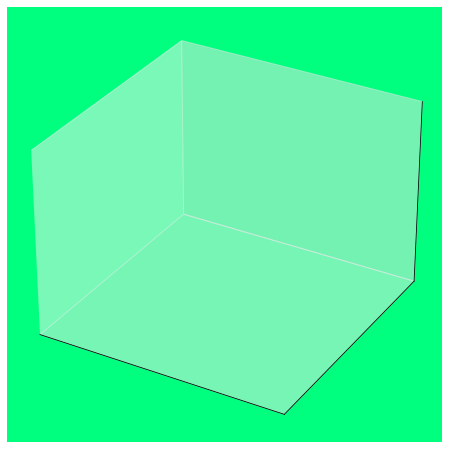

In [7]:
start = time.time()


n = 8
deltax = 1
deltat = 0.1
eta = 1
N = pow(2,n)
t = 0.5*N*deltax/deltat # light crossing time
t0 = 0.1
t2 = t/2 # half time
t5 = t/5
t10 = t/10 # 1/10 of the ligth crossing time

vel = np.zeros((N,N,N))
mu, sigma = 0, 0.1 # mean and standard deviation
omega = 5

print(t)



A1 = np.random.normal(mu, sigma, size=(N,N,N))
A2 = np.random.normal(mu,sigma,size=(N,N,N))



A1,A2 = wolff(N,t0,t2,A1,A2,vel,omega,eta,deltax,deltat)

end = time.time()
print(end - start)

In [24]:
# get colormap
ncolors = 256
color_array = plt.get_cmap('Greys_r')(range(ncolors))

# change alpha values
color_array[:,-1] = np.linspace(1.0,0.0,ncolors)

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='traal',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)


<ipython-input-24-3e44546384e5>:12: UserWarning: Trying to register the cmap 'traal' which already exists.
  plt.register_cmap(cmap=map_object)


In [ ]:
def cartesian_product_broadcasted(*arrays):
    """
    http://stackoverflow.com/a/11146645/190597 (senderle)
    """
    broadcastable = np.ix_(*arrays)
    broadcasted = np.broadcast_arrays(*broadcastable)
    dtype = np.result_type(*arrays)
    rows, cols = functools.reduce(np.multiply, broadcasted[0].shape), len(broadcasted)
    out = np.empty(rows * cols, dtype=dtype)
    start, end = 0, rows
    for a in broadcasted:
        out[start:end] = a.reshape(-1)
        start, end = end, end + rows
    return out.reshape(cols, rows).T
    
    
    
    fig = plt.figure(figsize=(8,8))
    #fig.set_facecolor('springgreen')
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_facecolor('springgreen')
    ax.set_axis_off()
    size = N
    x, y, z = cartesian_product_broadcasted(*[np.arange(size, dtype='int16')]*3).T
    mask = ((x == 0) | (x == size-1) 
            | (y == 0) | (y == size-1) 
            | (z == 0) | (z == size-1))
    x = x[mask]
    y = y[mask]
    z = z[mask]


In [2]:
# comoving but the strings stay put (ideal for radiation or matter)


@jit(nopython = True)
def Laplacian(A,deltax,deltat):

    h = len(A)
    #CFL condition delta x => sqrt(D) delta t, where D is the number of dimensions            
    P = np.zeros((h,h,h))
    result = np.zeros((h,h,h))

  
    for i in range(0, h):
        for j in range(0,h):
            for k in range(0,h):
                P[i,j,k] = (A[(i-1)%h,(j-1)%h,(k-1)%h] + 3*A[(i-1)%h,j,(k-1)%h] + A[(i-1)%h,(j+1)%h,(k-1)%h] \
                + 3*A[(i-1)%h,(j-1)%h,k] + 14*A[(i-1)%h,j,k] + 3*A[(i-1)%h,(j+1)%h,k] \
                + A[(i-1)%h,(j-1)%h,(k+1)%h] + 3*A[(i-1)%h,j,(k+1)%h] + A[(i-1)%h,(j+1)%h,(k+1)%h] \
                + 3*A[i,(j-1)%h,(k-1)%h] + 14*A[i,j,(k-1)%h] + 3*A[i,(j+1)%h,(k-1)%h] \
                + 14*A[i,(j-1)%h,k] - 128*A[i,j,k] + 14*A[i,(j+1)%h,k] \
                + 3*A[i,(j-1)%h,(k+1)%h] + 14*A[i,j,(k+1)%h] + 3*A[i,(j+1)%h,(k+1)%h] \
                + A[(i+1)%h,(j-1)%h,(k-1)%h] + 3*A[(i+1)%h,j,(k-1)%h] + A[(i+1)%h,(j+1)%h,(k-1)%h] \
                + 3*A[(i+1)%h,(j-1)%h,k] + 14*A[(i+1)%h,j,k] + 3*A[(i+1)%h,(j+1)%h,k] \
                + A[(i+1)%h,(j-1)%h,(k+1)%h] + 3*A[(i+1)%h,j,(k+1)%h] + A[(i+1)%h,(j+1)%h,(k+1)%h])/(30*pow(deltax,2))
    return P 


def update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,a,time):
    H_0 = 2.18e-18
    #a = np.sqrt(2*H_0)*np.sqrt(time)
    a = 4.75240000000367e-36 * time**2
    beta = 0
    alpha = 3
    #era = 1 #radiation
    era = 2 #matter

    lam = 2*pow(math.pi,2)/pow(omega,2)
    

    
    F1 = Laplacian(A1,deltax,deltat) - a**beta * lam*A1*(pow(A1,2)+pow(A2,2)-pow(eta,2))-alpha*era*vel1*1/time
    F2 = Laplacian(A2,deltax,deltat) - a**beta * lam*A2*(pow(A1,2)+pow(A2,2)-pow(eta,2))-alpha*era*vel2*1/time
    
    time = time + deltat
    
    a1 = 4.75240000000367e-36 * time**2

    
    A1 = A1 + deltat*(vel1 + 0.5*deltat*F1) 
    A2 = A2 + deltat*(vel2 + 0.5*deltat*F2) 

    
    vel1 = vel1 + deltat/2*(F1 + Laplacian(A1,deltax,deltat) - a1**beta *lam*A1*(pow(A1,2)+pow(A2,2)-pow(eta,2)) -alpha*era*vel1*1/time) 
    vel2 = vel2 + deltat/2*(F2 + Laplacian(A2,deltax,deltat) - a1**beta *lam*A2*(pow(A1,2)+pow(A2,2)-pow(eta,2)) -alpha*era*vel2*1/time)
    
    
    return A1,A2,vel1,vel2,a,time
    
    
#change the values accordlingly    
def wolff(N,t0,t,A1,A2,vel,omega,eta,deltax,deltat):

    time = t0
    a = 0

    vel1 = vel
    vel2 = vel
    

    fig = plt.figure(figsize=(8,8))
    #fig.set_facecolor('springgreen')
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_facecolor('springgreen')
    #ax.set_axis_off()
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    m = 0
    
    #ones = np.ones((N,N,N))
    #ones = np.where(ones > 0)
    #ax.scatter(ones[0],ones[1],ones[2],color = 'purple',alpha = 0.1)
    

 
    #angle = np.arctan2(A2,A1)



    for i in np.arange(int(t/deltat)):
        time = round(time,2)
        
        if time <= m*5: 
            if time % 5 == 0:
                mod = np.where(np.sqrt(pow(A1,2)+pow(A2,2))**1 < 0.5)

                scat = ax.scatter(mod[0],mod[1],mod[2],color= 'black')

                plt.savefig('122/'+str(int(time/5)).zfill(3)+'.png')

                scat.remove()
                    
        else:        
        
            if time % 1 == 0:

                mod = np.where(np.sqrt(pow(A1,2)+pow(A2,2))**1 < 0.5)

                scat = ax.scatter(mod[0],mod[1],mod[2],color= 'black')

                plt.savefig('122/'+str(int(time-m*4)).zfill(3)+'.png')

                scat.remove()
                    

            
        A1,A2,vel1,vel2,a,time = update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,a,time)


    return A1,A2

1280.0
14662.82998585701


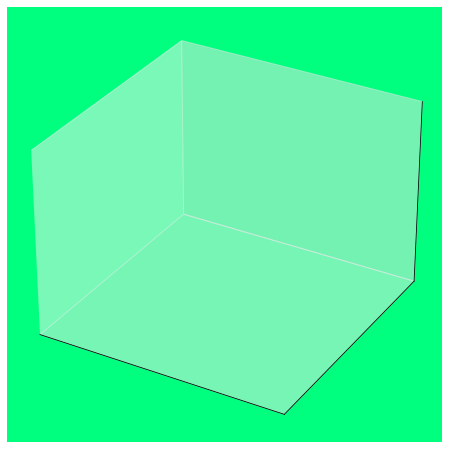

In [3]:
start = time.time()


n = 8
deltax = 1
deltat = 0.1
eta = 1
N = pow(2,n)
t = 0.5*N*deltax/deltat # light crossing time
t0 = 0.1
t2 = t/2 # half time
t5 = t/5
t10 = t/10 # 1/10 of the ligth crossing time

vel = np.zeros((N,N,N))
mu, sigma = 0, 0.1 # mean and standard deviation
omega = 5

print(t)



A1 = np.random.normal(mu, sigma, size=(N,N,N))
A2 = np.random.normal(mu,sigma,size=(N,N,N))



A1,A2 = wolff(N,t0,t5,A1,A2,vel,omega,eta,deltax,deltat)

end = time.time()
print(end - start)

In [4]:
# comoving but the strings stay put (ideal for radiation or matter)


@jit(nopython = True)
def Laplacian(A,deltax,deltat):

    h = len(A)
    #CFL condition delta x => sqrt(D) delta t, where D is the number of dimensions            
    P = np.zeros((h,h,h))
    result = np.zeros((h,h,h))

  
    for i in range(0, h):
        for j in range(0,h):
            for k in range(0,h):
                P[i,j,k] = (A[(i-1)%h,(j-1)%h,(k-1)%h] + 3*A[(i-1)%h,j,(k-1)%h] + A[(i-1)%h,(j+1)%h,(k-1)%h] \
                + 3*A[(i-1)%h,(j-1)%h,k] + 14*A[(i-1)%h,j,k] + 3*A[(i-1)%h,(j+1)%h,k] \
                + A[(i-1)%h,(j-1)%h,(k+1)%h] + 3*A[(i-1)%h,j,(k+1)%h] + A[(i-1)%h,(j+1)%h,(k+1)%h] \
                + 3*A[i,(j-1)%h,(k-1)%h] + 14*A[i,j,(k-1)%h] + 3*A[i,(j+1)%h,(k-1)%h] \
                + 14*A[i,(j-1)%h,k] - 128*A[i,j,k] + 14*A[i,(j+1)%h,k] \
                + 3*A[i,(j-1)%h,(k+1)%h] + 14*A[i,j,(k+1)%h] + 3*A[i,(j+1)%h,(k+1)%h] \
                + A[(i+1)%h,(j-1)%h,(k-1)%h] + 3*A[(i+1)%h,j,(k-1)%h] + A[(i+1)%h,(j+1)%h,(k-1)%h] \
                + 3*A[(i+1)%h,(j-1)%h,k] + 14*A[(i+1)%h,j,k] + 3*A[(i+1)%h,(j+1)%h,k] \
                + A[(i+1)%h,(j-1)%h,(k+1)%h] + 3*A[(i+1)%h,j,(k+1)%h] + A[(i+1)%h,(j+1)%h,(k+1)%h])/(30*pow(deltax,2))
    return P 


def update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,a,time):
    H_0 = 2.18e-18
    #a = np.sqrt(2*H_0)*np.sqrt(time)
    a = 4.36000000000006e-18 * time - 6.78288102293483e-23 
    beta = 0
    alpha = 3
    era = 1 #radiation
    #era = 2 #matter

    lam = 2*pow(math.pi,2)/pow(omega,2)
    

    
    F1 = Laplacian(A1,deltax,deltat) - a**beta * lam*A1*(pow(A1,2)+pow(A2,2)-pow(eta,2))-alpha*era*vel1*1/time
    F2 = Laplacian(A2,deltax,deltat) - a**beta * lam*A2*(pow(A1,2)+pow(A2,2)-pow(eta,2))-alpha*era*vel2*1/time
    
    time = time + deltat
    
    a1 = 4.36000000000006e-18 * time - 6.78288102293483e-23 

    
    A1 = A1 + deltat*(vel1 + 0.5*deltat*F1) 
    A2 = A2 + deltat*(vel2 + 0.5*deltat*F2) 

    
    vel1 = vel1 + deltat/2*(F1 + Laplacian(A1,deltax,deltat) - a1**beta *lam*A1*(pow(A1,2)+pow(A2,2)-pow(eta,2)) -alpha*era*vel1*1/time) 
    vel2 = vel2 + deltat/2*(F2 + Laplacian(A2,deltax,deltat) - a1**beta *lam*A2*(pow(A1,2)+pow(A2,2)-pow(eta,2)) -alpha*era*vel2*1/time)
    
    
    return A1,A2,vel1,vel2,a,time
    
    
#change the values accordlingly    
def wolff(N,t0,t,A1,A2,vel,omega,eta,deltax,deltat):

    time = t0
    a = 0

    vel1 = vel
    vel2 = vel
    

    fig = plt.figure(figsize=(8,8))
    #fig.set_facecolor('springgreen')
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_facecolor('springgreen')
    #ax.set_axis_off()
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    m = 0
    
    #ones = np.ones((N,N,N))
    #ones = np.where(ones > 0)
    #ax.scatter(ones[0],ones[1],ones[2],color = 'purple',alpha = 0.1)
    

 
    #angle = np.arctan2(A2,A1)



    for i in np.arange(int(t/deltat)):
        time = round(time,2)
        
        if time <= m*5: 
            if time % 5 == 0:
                mod = np.where(np.sqrt(pow(A1,2)+pow(A2,2))**1 < 0.5)

                scat = ax.scatter(mod[0],mod[1],mod[2],color= 'black')

                plt.savefig('121/'+str(int(time/5)).zfill(3)+'.png')

                scat.remove()
                    
        else:        
        
            if time % 1 == 0:

                mod = np.where(np.sqrt(pow(A1,2)+pow(A2,2))**1 < 0.5)

                scat = ax.scatter(mod[0],mod[1],mod[2],color= 'black')

                plt.savefig('121/'+str(int(time-m*4)).zfill(3)+'.png')

                scat.remove()
                    

            
        A1,A2,vel1,vel2,a,time = update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,a,time)


    return A1,A2

1280.0
13707.062996149063


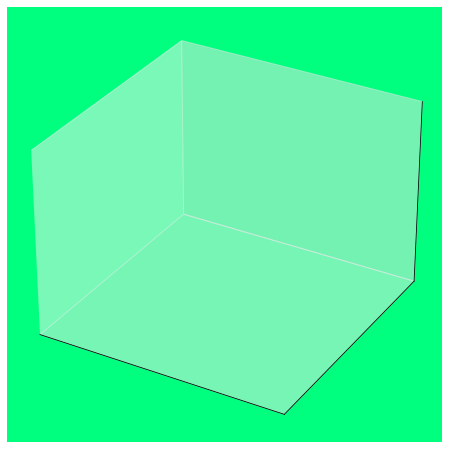

In [5]:
start = time.time()


n = 8
deltax = 1
deltat = 0.1
eta = 1
N = pow(2,n)
t = 0.5*N*deltax/deltat # light crossing time
t0 = 0.1
t2 = t/2 # half time
t5 = t/5
t10 = t/10 # 1/10 of the ligth crossing time

vel = np.zeros((N,N,N))
mu, sigma = 0, 0.1 # mean and standard deviation
omega = 5

print(t)



A1 = np.random.normal(mu, sigma, size=(N,N,N))
A2 = np.random.normal(mu,sigma,size=(N,N,N))



A1,A2 = wolff(N,t0,t5,A1,A2,vel,omega,eta,deltax,deltat)

end = time.time()
print(end - start)

In [8]:
# comoving but the strings stay put (ideal for radiation or matter)


@jit(nopython = True)
def Laplacian(A,deltax,deltat):

    h = len(A)
    #CFL condition delta x => sqrt(D) delta t, where D is the number of dimensions            
    P = np.zeros((h,h,h))
    result = np.zeros((h,h,h))

  
    for i in range(0, h):
        for j in range(0,h):
            for k in range(0,h):
                P[i,j,k] = (A[(i-1)%h,(j-1)%h,(k-1)%h] + 3*A[(i-1)%h,j,(k-1)%h] + A[(i-1)%h,(j+1)%h,(k-1)%h] \
                + 3*A[(i-1)%h,(j-1)%h,k] + 14*A[(i-1)%h,j,k] + 3*A[(i-1)%h,(j+1)%h,k] \
                + A[(i-1)%h,(j-1)%h,(k+1)%h] + 3*A[(i-1)%h,j,(k+1)%h] + A[(i-1)%h,(j+1)%h,(k+1)%h] \
                + 3*A[i,(j-1)%h,(k-1)%h] + 14*A[i,j,(k-1)%h] + 3*A[i,(j+1)%h,(k-1)%h] \
                + 14*A[i,(j-1)%h,k] - 128*A[i,j,k] + 14*A[i,(j+1)%h,k] \
                + 3*A[i,(j-1)%h,(k+1)%h] + 14*A[i,j,(k+1)%h] + 3*A[i,(j+1)%h,(k+1)%h] \
                + A[(i+1)%h,(j-1)%h,(k-1)%h] + 3*A[(i+1)%h,j,(k-1)%h] + A[(i+1)%h,(j+1)%h,(k-1)%h] \
                + 3*A[(i+1)%h,(j-1)%h,k] + 14*A[(i+1)%h,j,k] + 3*A[(i+1)%h,(j+1)%h,k] \
                + A[(i+1)%h,(j-1)%h,(k+1)%h] + 3*A[(i+1)%h,j,(k+1)%h] + A[(i+1)%h,(j+1)%h,(k+1)%h])/(30*pow(deltax,2))
    return P 


def update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,a,time):

    a = 2.93282351932618e-37 * time **2
    beta = 0
    alpha = 3
    #era = 1 #radiation
    era = 2 #matter

    lam = 2*pow(math.pi,2)/pow(omega,2)
    

    
    F1 = Laplacian(A1,deltax,deltat) - a**beta * lam*A1*(pow(A1,2)+pow(A2,2)-pow(eta,2))-alpha*era*vel1*1/time
    F2 = Laplacian(A2,deltax,deltat) - a**beta * lam*A2*(pow(A1,2)+pow(A2,2)-pow(eta,2))-alpha*era*vel2*1/time
    
    time = time + deltat
    
    a1 = 2.93282351932618e-37 * time **2

    
    A1 = A1 + deltat*(vel1 + 0.5*deltat*F1) 
    A2 = A2 + deltat*(vel2 + 0.5*deltat*F2) 

    
    vel1 = vel1 + deltat/2*(F1 + Laplacian(A1,deltax,deltat) - a1**beta *lam*A1*(pow(A1,2)+pow(A2,2)-pow(eta,2)) -alpha*era*vel1*1/time) 
    vel2 = vel2 + deltat/2*(F2 + Laplacian(A2,deltax,deltat) - a1**beta *lam*A2*(pow(A1,2)+pow(A2,2)-pow(eta,2)) -alpha*era*vel2*1/time)
    
    
    return A1,A2,vel1,vel2,a,time
    
    
#change the values accordlingly    
def wolff(N,t0,t,A1,A2,vel,omega,eta,deltax,deltat):

    time = t0
    a = 0

    vel1 = vel
    vel2 = vel
    

    fig = plt.figure(figsize=(8,8))
    #fig.set_facecolor('springgreen')
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_facecolor('springgreen')
    #ax.set_axis_off()
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    m = 0
    
    #ones = np.ones((N,N,N))
    #ones = np.where(ones > 0)
    #ax.scatter(ones[0],ones[1],ones[2],color = 'purple',alpha = 0.1)
    

 
    #angle = np.arctan2(A2,A1)



    for i in np.arange(int(t/deltat)):
        time = round(time,2)
        
        if time <= m*5: 
            if time % 5 == 0:
                mod = np.where(np.sqrt(pow(A1,2)+pow(A2,2))**1 < 0.5)

                scat = ax.scatter(mod[0],mod[1],mod[2],color= 'black')

                plt.savefig('123/'+str(int(time/5)).zfill(3)+'.png')

                scat.remove()
                    
        else:        
        
            if time % 1 == 0:

                mod = np.where(np.sqrt(pow(A1,2)+pow(A2,2))**1 < 0.5)

                scat = ax.scatter(mod[0],mod[1],mod[2],color= 'black')

                plt.savefig('123/'+str(int(time-m*4)).zfill(3)+'.png')

                scat.remove()
                    

            
        A1,A2,vel1,vel2,a,time = update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,a,time)


    return A1,A2

1280.0
14870.515420913696


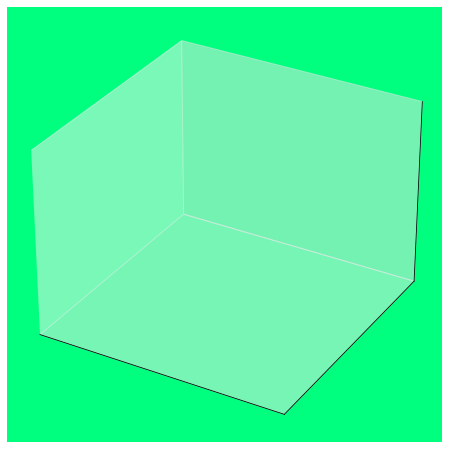

In [9]:
start = time.time()


n = 8
deltax = 1
deltat = 0.1
eta = 1
N = pow(2,n)
t = 0.5*N*deltax/deltat # light crossing time
t0 = 0.1
t2 = t/2 # half time
t5 = t/5
t10 = t/10 # 1/10 of the ligth crossing time

vel = np.zeros((N,N,N))
mu, sigma = 0, 0.1 # mean and standard deviation
omega = 5

print(t)



A1 = np.random.normal(mu, sigma, size=(N,N,N))
A2 = np.random.normal(mu,sigma,size=(N,N,N))



A1,A2 = wolff(N,t0,t5,A1,A2,vel,omega,eta,deltax,deltat)

end = time.time()
print(end - start)